In [62]:
import tensorflow as tf

# creating Dataset

In [68]:
import pandas as pd
df = pd.read_csv("eng_to_hin.csv")
df.head()
vocab_size = 50000
max_length = 100
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_hi = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_en.adapt(df.English)
text_vec_layer_hi.adapt([f"startofseq {s} endofseq" for s in df.Hindi])

X_train = tf.constant(df.English[:120])
X_valid = tf.constant(df.English[120:])
X_train_dec = tf.constant([f"startofseq {s}" for s in df.Hindi[:120]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in df.Hindi[120:]])
Y_train = text_vec_layer_hi([f"{s} endofseq" for s in df.Hindi[:120]])
Y_valid = text_vec_layer_hi([f"{s} endofseq" for s in df.Hindi[120:]])

# Creating model

In [69]:
text_vec_layer_en.vocabulary_size()

217

In [70]:
text_vec_layer_hi.vocabulary_size()

243

In [71]:
text_vec_layer_hi(["कृपया वह स्थान चुनें"])

<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[13,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]])>

In [124]:
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [125]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_hi(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(text_vec_layer_en.vocabulary_size(), embed_size,
                                                    mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(text_vec_layer_hi.vocabulary_size(), embed_size,
                                                    mask_zero=True)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [126]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

In [127]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [128]:
output_layer = tf.keras.layers.Dense(text_vec_layer_hi.vocabulary_size(), activation="softmax")
Y_proba = output_layer(decoder_outputs)

# training model

In [129]:
# Define the TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/content/logs")

In [131]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit((X_train, X_train_dec), Y_train, epochs=100,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/100
4/4 [==============================] - 13s 1s/step - loss: 5.4793 - accuracy: 0.2030 - val_loss: 5.3912 - val_accuracy: 0.3562
Epoch 2/100
4/4 [==============================] - 1s 184ms/step - loss: 5.1357 - accuracy: 0.2474 - val_loss: 4.1772 - val_accuracy: 0.2438
Epoch 3/100
4/4 [==============================] - 1s 231ms/step - loss: 4.2935 - accuracy: 0.2144 - val_loss: 3.8279 - val_accuracy: 0.2375
Epoch 4/100
4/4 [==============================] - 0s 146ms/step - loss: 3.9227 - accuracy: 0.2223 - val_loss: 3.3147 - val_accuracy: 0.2688
Epoch 5/100
4/4 [==============================] - 1s 230ms/step - loss: 3.6590 - accuracy: 0.2634 - val_loss: 3.1063 - val_accuracy: 0.3500
Epoch 6/100
4/4 [==============================] - 1s 238ms/step - loss: 3.4739 - accuracy: 0.3033 - val_loss: 2.9595 - val_accuracy: 0.5000
Epoch 7/100
4/4 [==============================] - 0s 111ms/step - loss: 3.3119 - accuracy: 0.3295 - val_loss: 2.9596 - val_accuracy: 0.5000
Epoch 8/100
4/4

In [132]:
import numpy as np
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_hi.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

In [133]:
X_train[:10]

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'Please wait a moment.', b"I don't understand.",
       b'Excuse me, where is the restroom?', b'What time is it?',
       b'How much does it cost?', b'Where can I find a taxi?',
       b'I am hungry.', b'I am thirsty.', b'I am tired.',
       b'Where is the nearest hospital?'], dtype=object)>

currently due to very less training our model spits out random things sometimes but still it has learned to maintain grammer

In [134]:
translate("Please wait a moment.")

1/1 [==============================] - 0s 29ms/step


'कृपया एक क्षण प्रतीक्षा करें।'

In [135]:
translate("I am hungry.")

1/1 [==============================] - 0s 20ms/step


'मुझे भूख लगी है।'

In [137]:
import matplotlib.pyplot as plt

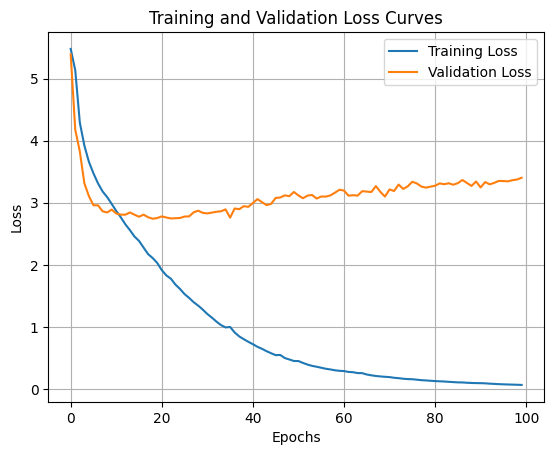

In [144]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Plot both training and validation loss curves
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid()
plt.show()

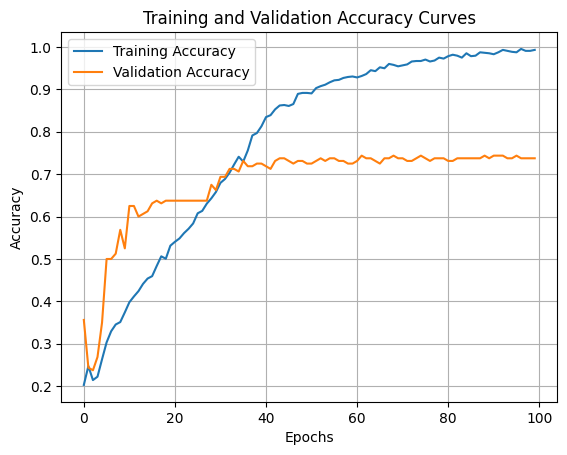

In [145]:
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']

# Plot both training and validation loss curves
plt.plot(acc_values, label='Training Accuracy')
plt.plot(val_acc_values, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.grid()
plt.show()

In [152]:
model.save("trained_translation_model")

In [153]:
!zip -r /content/translation_model.zip /content/trained_translation_model

  adding: content/trained_translation_model/ (stored 0%)
  adding: content/trained_translation_model/keras_metadata.pb (deflated 91%)
  adding: content/trained_translation_model/variables/ (stored 0%)
  adding: content/trained_translation_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/trained_translation_model/variables/variables.index (deflated 63%)
  adding: content/trained_translation_model/fingerprint.pb (stored 0%)
  adding: content/trained_translation_model/assets/ (stored 0%)
  adding: content/trained_translation_model/saved_model.pb (deflated 90%)
